In [16]:
DATA_PATH = "data/emotions"
FILES = ['train.txt', 'val.txt', 'test.txt']

                                            sentence  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  16000 non-null  object
 1   emotion   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
None

                                            sentence  emotion
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                     i feel like a faithful servant     love
3                  i am just feeling cranky and blue    anger
4  i can 

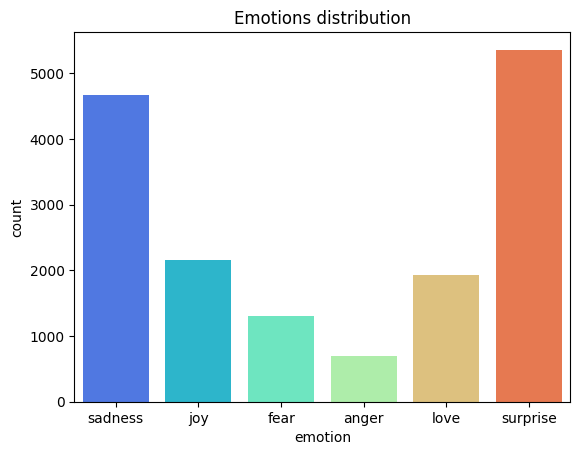

In [17]:
from pathlib import Path
from pandas import read_csv, DataFrame
from seaborn import countplot

def read_data_file(file_path: Path) -> DataFrame:
    # read csv with ; as separator
    df = read_csv(file_path, sep=';', header=None)

    # create header
    df.columns = ['sentence', 'emotion']

    # log dataset info
    print(df.head(), end='\n\n')
    print(df.info(), end='\n\n')
    countplot(x='emotion', data=df, palette='rainbow').set_title('Emotions distribution')

    return df

DATA = list(map(lambda file_name: read_data_file(Path(f"{DATA_PATH}/{file_name}")), FILES))

                                            sentence  emotion  length
0                            i didnt feel humiliated  sadness       4
1  i can go from feeling so hopeless to so damned...  sadness      21
2   im grabbing a minute to post i feel greedy wrong    anger      10
3  i am ever feeling nostalgic about the fireplac...     love      18
4                               i am feeling grouchy    anger       4


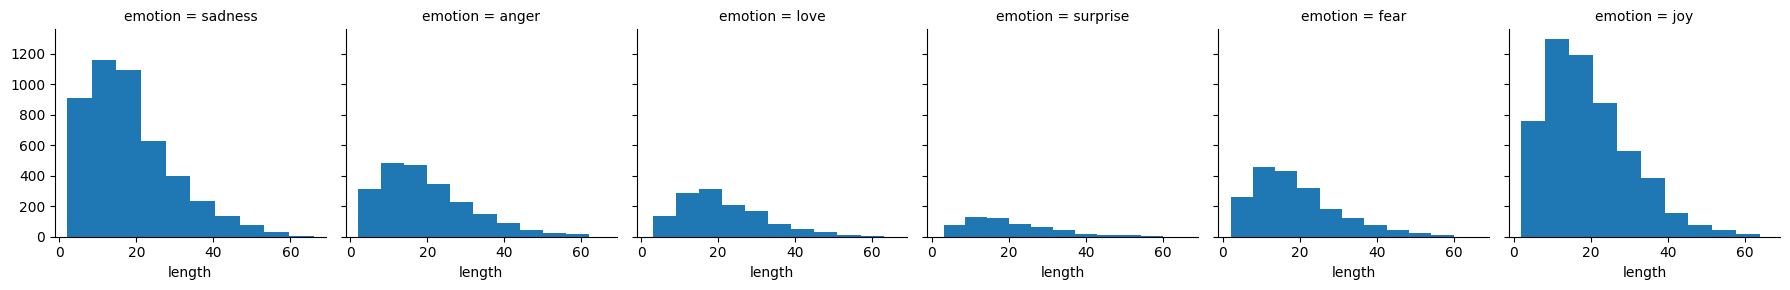

In [18]:
from seaborn import FacetGrid
from matplotlib.pyplot import hist

df_train = DATA[0]
df_train['length'] = df_train['sentence'].apply(lambda sentence: len(sentence.split(' ')))
print(df_train.head())

g = FacetGrid(df_train, col='emotion')
g.map(hist, 'length', color='#1f77b4')

                                            sentence  emotion  length
0                              didnt feel humiliated  sadness       3
1  can go from feeling so hopeless to so damned h...  sadness      20
2       im grabbing minute to post feel greedy wrong    anger       8
3  am ever feeling nostalgic about the fireplace ...     love      16
4                                 am feeling grouchy    anger       3


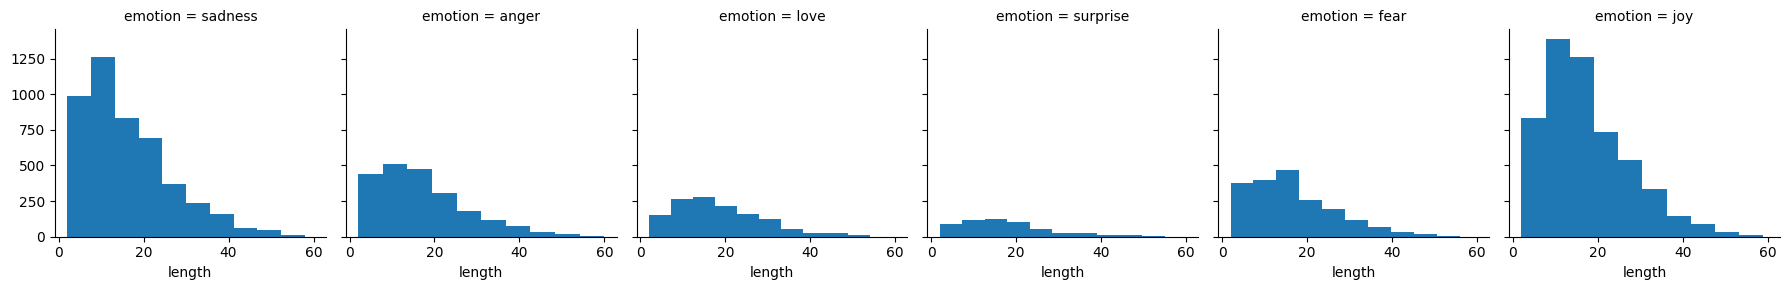

In [19]:
from string import punctuation
from os import environ

from sklearn.feature_extraction.text import CountVectorizer

# run python -m nltk.downloader stepwords, wordnet
# set nltk_data environment variable with the nltk_data path
environ['NLTK_DATA'] = '/Users/peterj/nltk_data'

def clean_sentence(sentence: str) -> str:
    # remove punctuation
    sentence = sentence.translate(str.maketrans('', '', punctuation))

    # tokenize
    tokenizer = CountVectorizer().build_tokenizer()
    sentence = ' '.join([word for word in tokenizer(sentence)])

    return sentence

df_train['sentence'] = df_train['sentence'].apply(clean_sentence)
df_train['length'] = df_train['sentence'].apply(lambda sentence: len(sentence.split(' ')))
print(df_train.head())

g = FacetGrid(df_train, col='emotion')
g.map(hist, 'length', color='#1f77b4')

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pickle import dump as dump_object

df_test = DATA[1]

tfidf = TfidfVectorizer()
m_tfidf_train = tfidf.fit_transform(df_train['sentence'])
y_train = df_train['emotion']
m_tfidf_test = tfidf.transform(df_test['sentence'])
y_test = df_test['emotion']

dump_object(tfidf, open('out/tf_idf.pkl', 'wb'))

In [21]:
# Models
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': BernoulliNB()
}

accuracies = {}

for model_name, model_instance in models.items():
    accuracies[model_name] = cross_val_score(model_instance, m_tfidf_train, y_train, scoring='accuracy', cv=StratifiedKFold(10)).mean()



/Users/peterj/Desktop/VSE/wm-sem/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/peterj/Desktop/VSE/wm-sem/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [22]:
acc = DataFrame({'Model': accuracies.keys(), 'Accuracy': accuracies.values()}).sort_values(by='Accuracy', ascending=False)
print(acc)

                 Model  Accuracy
1        Random Forest  0.856875
3  Logistic Regression  0.845437
0        Decision Tree  0.842938
2                  SVM  0.832750
4                  KNN  0.712438
5          Naive Bayes  0.658000


In [23]:
model_name = acc.iloc[0]['Model']
print(model_name)

model = models.get(model_name)
model.fit(m_tfidf_train, y_train)

pred = model.predict(m_tfidf_test)
model_name_lowercase = acc.iloc[0]['Model'].lower().replace(' ', '_')
dump_object(model, open(f'out/model_{model_name_lowercase}.pkl', 'wb'))

Random Forest


In [24]:
from pickle import load as load_object
from numpy import argmax

ml = load_object(open('out/model.pkl','rb'))
tfidf = load_object(open('out/tf_idf.pkl','rb'))

def ml_predict(sentence):
    cleaned_sentence = clean_sentence(sentence)
    tfid_matrix = tfidf.transform([cleaned_sentence])
    pred_prob = ml.predict_proba(tfid_matrix)
    idx = argmax(pred_prob)
    pred = ml.classes_[idx]
    
    return pred, pred_prob[0][idx]

ml_predict('poor room service')

ValueError: X has 15186 features, but RandomForestClassifier is expecting 13435 features as input.